In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

import scico.numpy as snp
import scico.random as random
from scico import functional, linop, loss, metric, plot, random
from scico.functional import L1Norm, L21Norm, ZeroFunctional
from scico.optimize.admm import ADMM, LinearSubproblemSolver, G0BlockCircularConvolveSolver
from scico.util import device_info
plot.config_notebook_plotting()

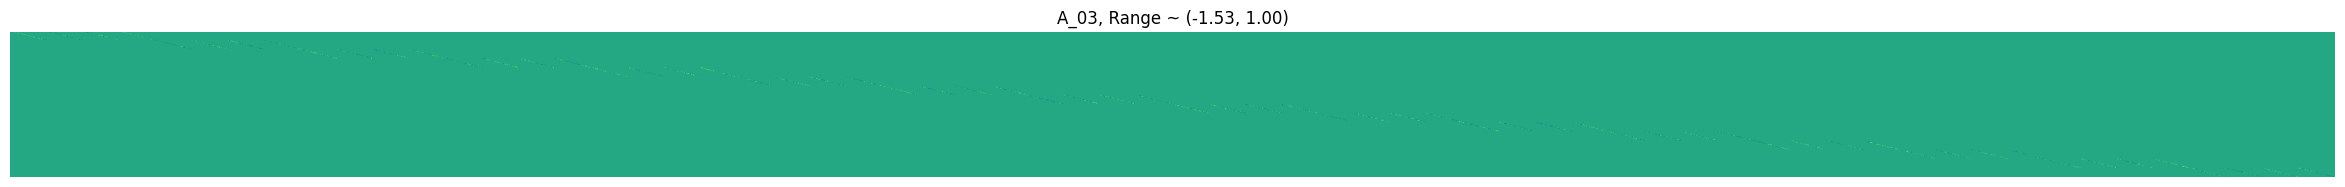

In [5]:
data = loadmat("./data/dataset/jellyfish/Jellyfish_4x4-patches.mat")
A_stacked = data['A'].reshape(64, 256, 4096)
Y = data['y'].reshape(256, 64)

IT = 2
plt.figure(figsize=(30,10))
plt.imshow(A_stacked[IT])
plt.title(f"A_{IT+1:02}, Range ~ ({A_stacked[IT].min():.2f}, {A_stacked[IT].max():.2f})")
plt.axis('off')
plt.show()

### PnP

Solving on CPU

Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  6.24e-01  6.444e+01  8.716e+02     20  1.895e-10
   1  1.17e+00  3.267e+01  6.143e+02     20  6.027e-11
   2  1.71e+00  2.345e+01  4.491e+02     19  8.698e-11
   3  2.24e+00  1.783e+01  3.447e+02     19  5.021e-11
   4  2.79e+00  1.404e+01  2.727e+02     19  3.397e-11
   5  3.31e+00  1.129e+01  2.205e+02     18  7.626e-11
   6  3.83e+00  9.272e+00  1.812e+02     18  5.592e-11
   7  4.36e+00  7.740e+00  1.509e+02     18  4.257e-11
   8  4.88e+00  6.532e+00  1.268e+02     18  3.296e-11
   9  5.39e+00  5.547e+00  1.074e+02     17  7.957e-11
  10  5.89e+00  4.833e+00  9.157e+01     17  6.582e-11
  11  6.40e+00  4.144e+00  7.853e+01     17  5.418e-11
  12  6.91e+00  3.576e+00  6.761e+01     17  4.298e-11
  13  7.43e+00  3.156e+00  5.851e+01     17  3.854e-11
  14  7.93e+00  2.807e+00  5.078e+01     17  3.174e-11
  15  8.44e+00  2.469e+00  4.419e+01     16  8.38

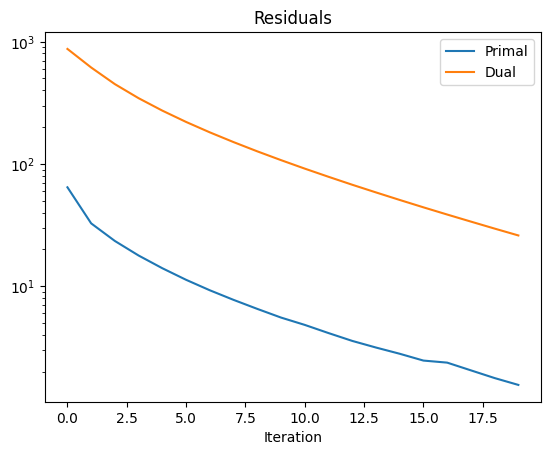

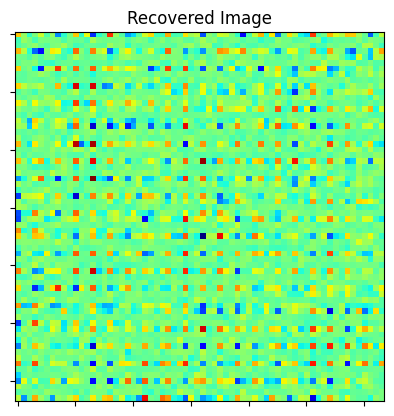

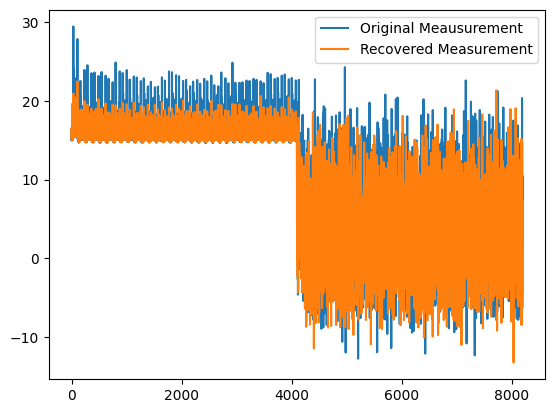

In [9]:
s_limit, e_limit = 0,8192
phi = snp.array(A_stacked.reshape(-1, 4096))[s_limit:e_limit]
y = snp.array(Y.reshape(-1))[s_limit:e_limit]/8

Afn = lambda x: phi@x.flatten()
A = linop.LinearOperator(input_shape = (64,64), output_shape = y.shape, eval_fn=Afn)

λ1, λ2, λ3 = 0, .8, 0
g1 = λ1 * functional.DnCNN("17H")
g2 =  λ2*functional.BM3D()
g3 =  λ3*functional.L1Norm()

ρ1, ρ2, ρ3= 5, 1, 5     # ADMM penalty parameter
maxiter = 20            # number of ADMM iterations



f = loss.SquaredL2Loss(y=y, A=A)
C = linop.Identity((64,64))

x_init = (A.T @ y)
x_init = x_init/x_init.max()

solver = ADMM(
    f=f,
    g_list=[g1, g2, g3],
    C_list=[C, C, C],
    rho_list=[ρ1, ρ2,ρ3 ],
    x0=x_init,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-10, "maxiter": 20}),
    itstat_options={"display": True},
)


print(f"Solving on {device_info()}\n")
x = solver.solve()
# x = snp.clip(x, 0, 1)
hist = solver.itstat_object.history(transpose=True)


plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title=f"Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
)

plot.imview(x,cmap = "jet", title=f"Recovered Image")

p = np.vstack((np.array(y), np.array(A(x))))
plot.plot(p.reshape(-1,2), lgnd=["Original Meausurement", "Recovered Measurement"])